# Spaceship Titanic 
https://www.kaggle.com/competitions/spaceship-titanic/overview


#### File and Data Field Descriptions

**train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data. 

- **PassengerId**: 
  - A unique Id for each passenger. 
  - Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and `pp` is their number within the group. 
  - People in a group are often family members, but not always.
- **HomePlanet**: 
  - The planet the passenger departed from, typically their planet of permanent residence.
- **CryoSleep**: 
  - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. 
  - Passengers in cryosleep are confined to their cabins.
- **Cabin**: 
  - The cabin number where the passenger is staying. 
  - Takes the form `deck/num/side`, where side can be either `P` for Port or `S` for Starboard.
- **Destination**: 
  - The planet the passenger will be debarking to.
- **Age**: 
  - The age of the passenger.
- **VIP**: 
  - Whether the passenger has paid for special VIP service during the voyage.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck**: 
  - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **Name**: 
  - The first and last names of the passenger.
- **Transported**: 
  - Whether the passenger was transported to another dimension. 
  - This is the target, the column you are trying to predict.
<br><br>

**test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of `Transported` for the passengers in this set.




import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
pd.set_option('display.max_columns', None)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 mins 37 secs
H2O_cluster_timezone:,Etc/GMT
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_unknownUser_3non7r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.705 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Load data

In [2]:
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')

### Feature extraction based on dataset description

In [3]:
# group details
def process_id_col(df: pd.DataFrame) -> pd.DataFrame:

    if 'PassengerId' in df.columns:
        df[['GroupNum', 'NumInGroup']] = df['PassengerId'].str.split('_', expand=True)
        df['NumInGroup'] = df['NumInGroup'].astype(int)
        df['GroupSize'] = df.groupby('GroupNum')['NumInGroup'].transform('max')
        df = df.drop(columns=['PassengerId', 'NumInGroup'])
        
        return df
    
data_train = process_id_col(data_train)

In [4]:
# cabin details
def process_cabin_col(df: pd.DataFrame) -> pd.DataFrame:

    if 'Cabin' in df.columns:
        df[['CabinDeck', 'CabinNum', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)
        df = df.drop(columns=['Cabin'])


    return df

data_train = process_cabin_col(data_train)

In [5]:
# find surnames
def process_name_col(df: pd.DataFrame) -> pd.DataFrame:

    if 'Name' in df.columns:
        df['Surname'] = df['Name'].str.split(' ').str[-1]
        df = df.drop(columns=['Name'])

    return df

data_train = process_name_col(data_train)


In [6]:
# check if travelling alone

def process_alone(df: pd.DataFrame) -> pd.DataFrame:
    
    df['Alone'] = df['GroupSize'] == 1
    
    return df


data_train = process_alone(data_train)

In [7]:
# check if theres family members in the passenger group 

def process_family(df: pd.DataFrame) -> pd.DataFrame:
    
    # find number of group members with the same surname
    group_counts = df.groupby(['GroupNum', 'Surname']).size().reset_index(name='SameGroupSurnameCount')
    df = df.merge(group_counts, on=['GroupNum', 'Surname'], how='left')

    # add column
    df['WithFamily'] = df['SameGroupSurnameCount'] > 1
    
    # remove temp columns
    df = df.drop(columns=['SameGroupSurnameCount'])

    return df


data_train = process_family(data_train)

### Data overview

- statistical importance
- missing values

In [8]:
data_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupNum,GroupSize,CabinDeck,CabinNum,CabinSide,Surname,Alone,WithFamily
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,1,B,0,P,Ofracculy,True,False
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,1,F,0,S,Vines,True,False
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,2,A,0,S,Susent,False,True
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,2,A,0,S,Susent,False,True
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,1,F,1,S,Santantines,True,False


Numeric data

In [9]:
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0
GroupSize,8693.0,2.035546,1.596347,1.0,1.0,1.0,3.0,8.0


Categorical data

In [10]:
data_train.describe(include=['object', 'bool']).T

,count,unique,top,freq
HomePlanet,8492,3,Earth,4602
CryoSleep,8476,2,False,5439
Destination,8511,3,TRAPPIST-1e,5915
VIP,8490,2,False,8291
Transported,8693,2,True,4378
GroupNum,8693,6217,4498,8
CabinDeck,8494,8,F,2794
CabinNum,8494,1817,82,28
CabinSide,8494,2,S,4288
Surname,8493,2217,Casonston,18


#### Columns with a large number of unique values

**GroupNum, CabinNum, Surname** have large number of unique categorical values. Potential correlation of these columns will be chcekd with **p-value**

In [11]:
def check_stat_importance(df: pd.DataFrame, columns: List[int], target_col: str):

    for col in columns:
        contingency_table = pd.crosstab(data_train[col], data_train[target_col])
        chi2, p, _, _ = chi2_contingency(contingency_table)

        print(f'Column: {col}')
        print(f'Chi2 value {chi2}')
        print(f'P value: {p}\n')


check_stat_importance(data_train, columns=['GroupNum', 'CabinNum', 'Surname'], target_col='Transported')

Column: GroupNum
Chi2 value 6494.108319206162
P value: 0.006870372304261477

Column: CabinNum
Chi2 value 1996.3773737464164
P value: 0.0018055974346714817

Column: Surname
Chi2 value 2541.7071229836893
P value: 1.4251580122746516e-06



- **GroupNum** and **CabinNum** are statistically significant ( p-value <0.05)
    - due to number of classes columns will be treated as ***continous values***
    - missing values will be replaced by 0 
<br><br>
- **Surname** column will be rejected due to high p-value and problematic encoding




In [12]:
def process_numerous_cat_cols(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:

    for col in columns:
        df[col] = df[col].fillna(0).astype(int)
        df[col] = df[col].astype(int)

    return df

data_train = process_numerous_cat_cols(data_train, columns=['GroupNum', 'CabinNum'])
data_train = data_train.drop(columns=['Surname'])

#### The rest of categorical/binary columns

In [13]:
cat_columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck', 'CabinSide', 'Alone', 'WithFamily'  ]
check_stat_importance(data_train, columns=cat_columns, target_col='Transported')

Column: HomePlanet
Chi2 value 324.9013834000382
P value: 2.809059985251311e-71

Column: CryoSleep
Chi2 value 1859.6127129888841
P value: 0.0

Column: Destination
Chi2 value 106.39215684982227
P value: 7.892901466137099e-24

Column: VIP
Chi2 value 11.542020738162797
P value: 0.0006804064556968345

Column: CabinDeck
Chi2 value 392.2880411997481
P value: 1.0743307258871414e-80

Column: CabinSide
Chi2 value 91.0595970786772
P value: 1.3940936254458288e-21

Column: Alone
Chi2 value 112.10432824383432
P value: 3.389940608159667e-26

Column: WithFamily
Chi2 value 86.77451036993212
P value: 1.2162705957770052e-20



Most statistical significant are **VIP** and **CryoSleep**

#### Continous columns

In [14]:
def check_stat_importance_continuous(df: pd.DataFrame, columns: List[str], target_col: str):
    for col in columns:
        group1 = df[df[target_col] == 0][col].dropna()  # Uwzględnienie przypadku, gdy są brakujące wartości
        group2 = df[df[target_col] == 1][col].dropna()  # Uwzględnienie przypadku, gdy są brakujące wartości

        t_stat, p_value = ttest_ind(group1, group2)

        print(f'Column: {col}')
        print(f'T-statistic value: {t_stat}')
        print(f'P value: {p_value}\n')

continous_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupSize' ]

check_stat_importance_continuous(data_train, columns=continous_columns, target_col='Transported')

Column: Age
T-statistic value: 6.941461666045089
P value: 4.165050977554494e-12

Column: RoomService
T-statistic value: 23.27230572812196
P value: 3.400493892669515e-116

Column: FoodCourt
T-statistic value: -4.299893771259008
P value: 1.727865340729664e-05

Column: ShoppingMall
T-statistic value: -0.934056481671101
P value: 0.3503013444989256

Column: Spa
T-statistic value: 20.914657362229097
P value: 9.275825095363414e-95

Column: VRDeck
T-statistic value: 19.517825470012635
P value: 4.9897017399892476e-83

Column: GroupSize
T-statistic value: -7.730995133820079
P value: 1.1860471813090583e-14



#### Missing data

In [15]:
def missing_data_summary(df: pd.DataFrame) -> pd.DataFrame:
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent (%)'])

missing_summary = missing_data_summary(data_train)
missing_summary

,Total Missing,Percent (%)
CryoSleep,217,2.496261
ShoppingMall,208,2.392730
VIP,203,2.335212
HomePlanet,201,2.312205
CabinSide,199,2.289198
CabinDeck,199,2.289198
VRDeck,188,2.162660
FoodCourt,183,2.105142
Spa,183,2.105142
Destination,182,2.093639


In [16]:
def count_rows_removed_after_dropna(df: pd.DataFrame) -> int:

    initial_rows = df.shape[0]
    after_dropna_rows = df.dropna().shape[0]
    rows_removed = initial_rows - after_dropna_rows
    
    return rows_removed

count_rows_removed_after_dropna(data_train)

1929

There are about 200 missing samples in 12 categories, by deleting all samples with a missing value will remove 1929 rows, which is too much. <br>

On that moment missing values will be replaced by **median**. In the next stage there will be experiments with diffrent types of dealing with these values, such as:
- filling na basing on the internal feature connections / correlations
- median
- ML predictions

In [17]:
def fillna_with_mode(df: pd.DataFrame) -> pd.DataFrame:

    for col in df.columns:
        mode_value = df[col].mode().iloc[0]
        df[col].fillna(mode_value, inplace=True)
    
    return df

# data_train = fillna_with_mode(data_train)

### Exploration with visualisations

#### Correlations between features

Internal correlations between features can help to find missing values

In [18]:
# one hot encoding
columns_to_decode=['HomePlanet', 'Destination', 'CabinSide', 'CabinDeck' ]
data_train_encoded = pd.get_dummies(data_train, columns=columns_to_decode)

# move target to the end
transported_col = data_train_encoded.pop('Transported')
data_train_encoded['Transported'] = transported_col


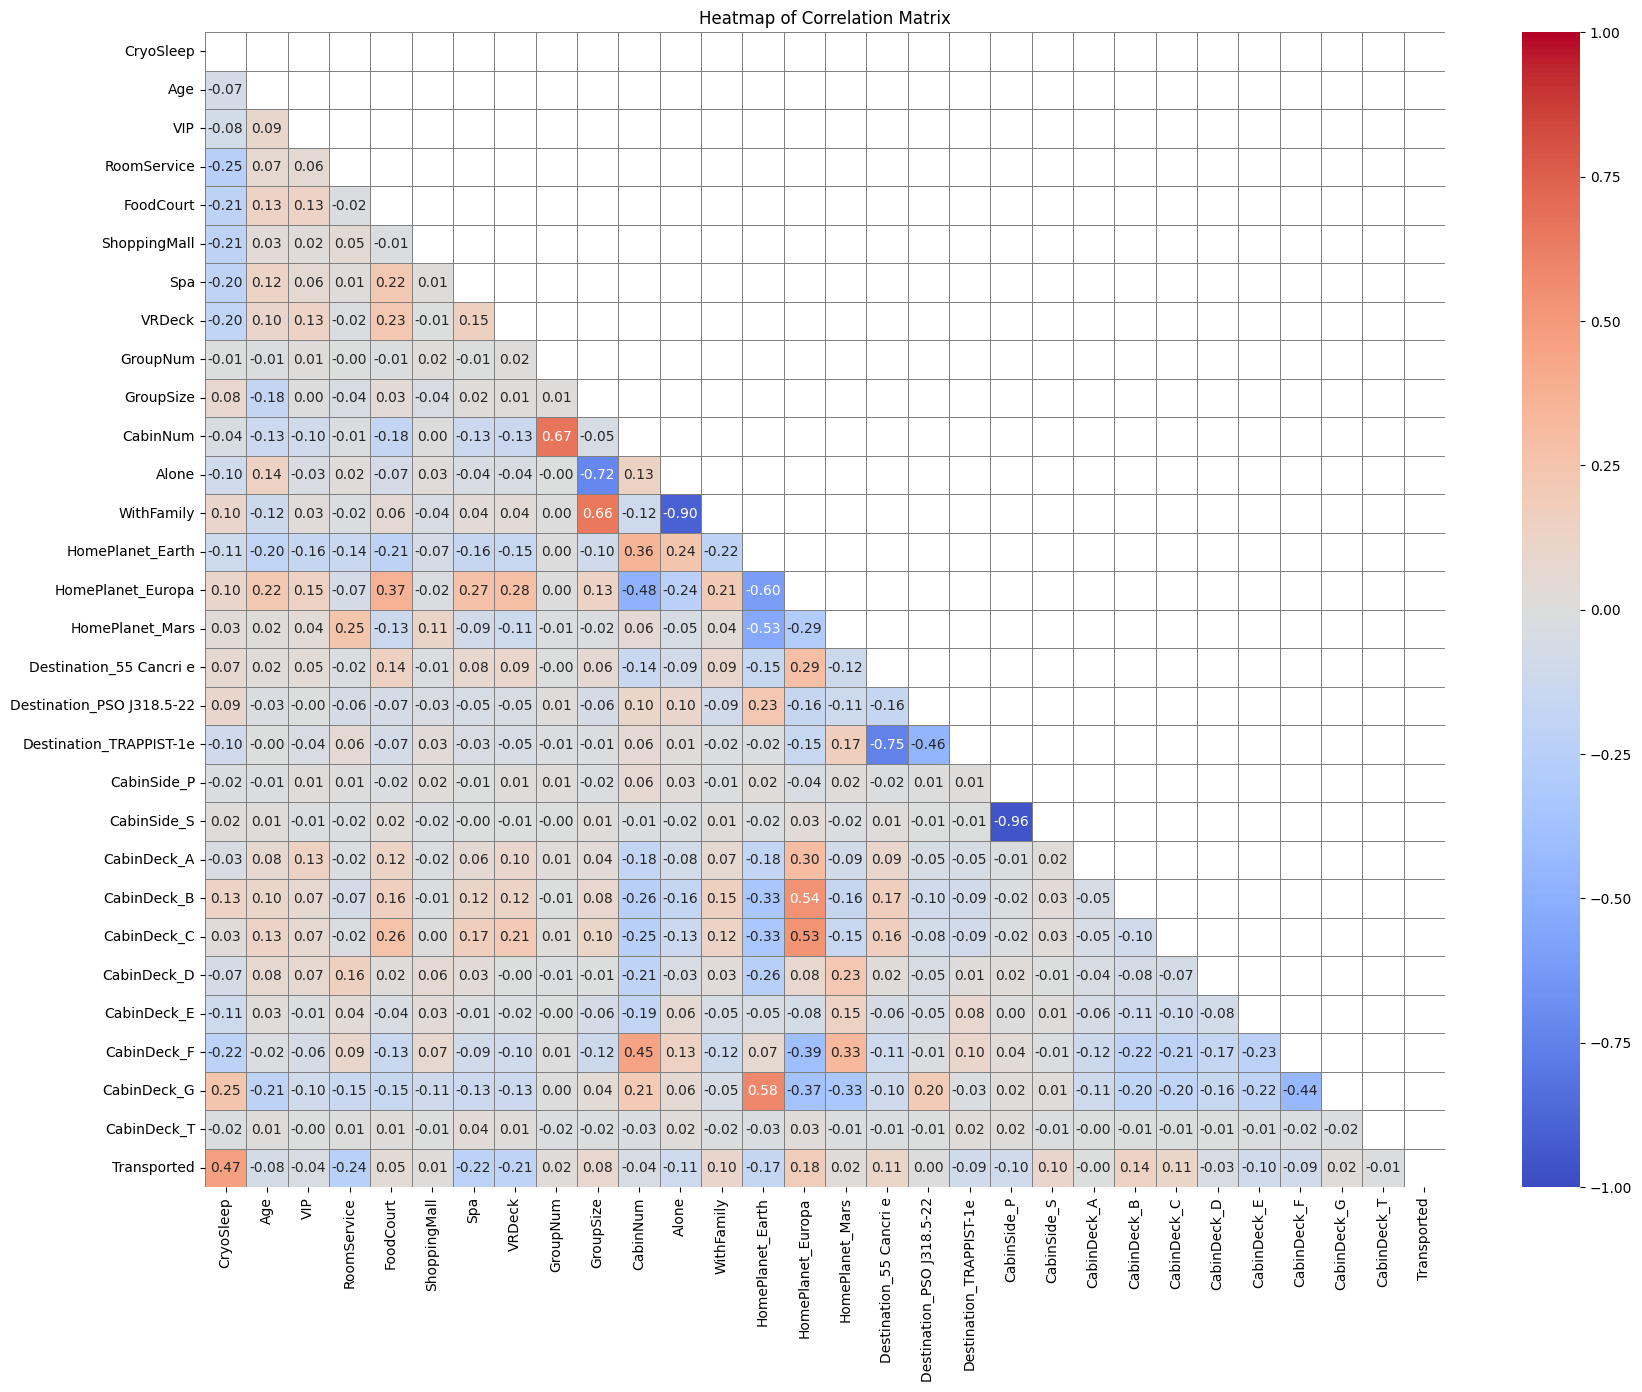

In [19]:
corr = data_train_encoded.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask, fmt=".2f", linewidths=0.5, linecolor='gray')
plt.title('Heatmap of Correlation Matrix')
plt.show()


##### Correlation heatmap conclusions:
There is a need of investigation the following potential correlations:
- CryoSleep and CabinDeck
- CryoSleep and expenses on services
- CryoSleep and Age



TBD

#### Dtale

In [20]:
# df_copy = data_train_encoded.copy()
# df_copy.reset_index(drop=True, inplace=True)
# df_copy.dropna(inplace=True)


# for col in df_copy.columns:
#     df_copy[col] = df_copy[col].astype(float)

# # 4. Załaduj do dtale
# d = dtale.show(df_copy)


In [21]:
# d.kill()

##### CryoSleep and Services

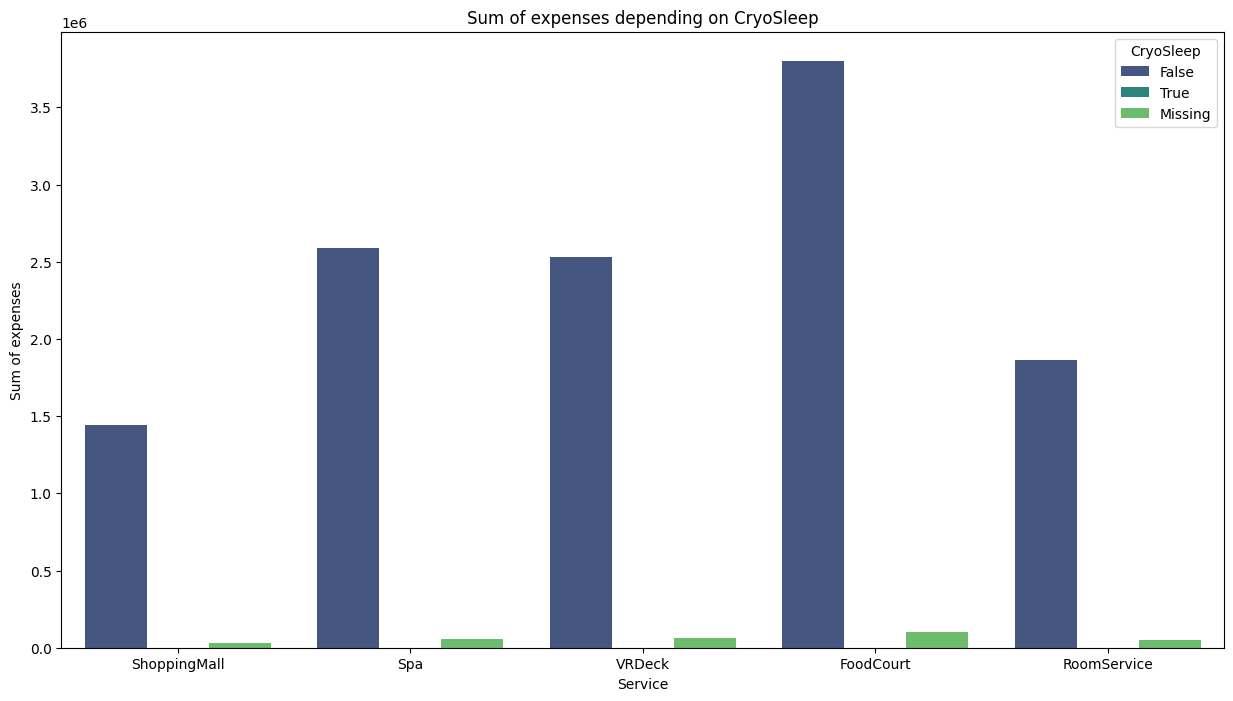

In [22]:
df = data_train.copy()

df['CryoSleep'].fillna('Missing', inplace=True)

grouped_data = df.groupby('CryoSleep')[['ShoppingMall', 'Spa', 'VRDeck', 'FoodCourt', 'RoomService']].sum().reset_index()

melted_data = pd.melt(grouped_data, id_vars='CryoSleep', value_vars=['ShoppingMall', 'Spa', 'VRDeck', 'FoodCourt', 'RoomService'], 
                      var_name='Service', value_name='Value')

plt.figure(figsize=(15, 8))
sns.barplot(x='Service', y='Value', hue='CryoSleep', data=melted_data, palette="viridis")

plt.ylabel('Sum of expenses')
plt.title('Sum of expenses depending on CryoSleep')
plt.legend(title='CryoSleep')
plt.show()

According to the graph, it can be seen that passengers staying in CryoSleep did not use paid services. 

It is possible to reconstruct the missing data based on the following dependencies

- CryoSleep based on the amounts spent
- Services amounts as zero based on CryoSleep



##### VIP and Age 

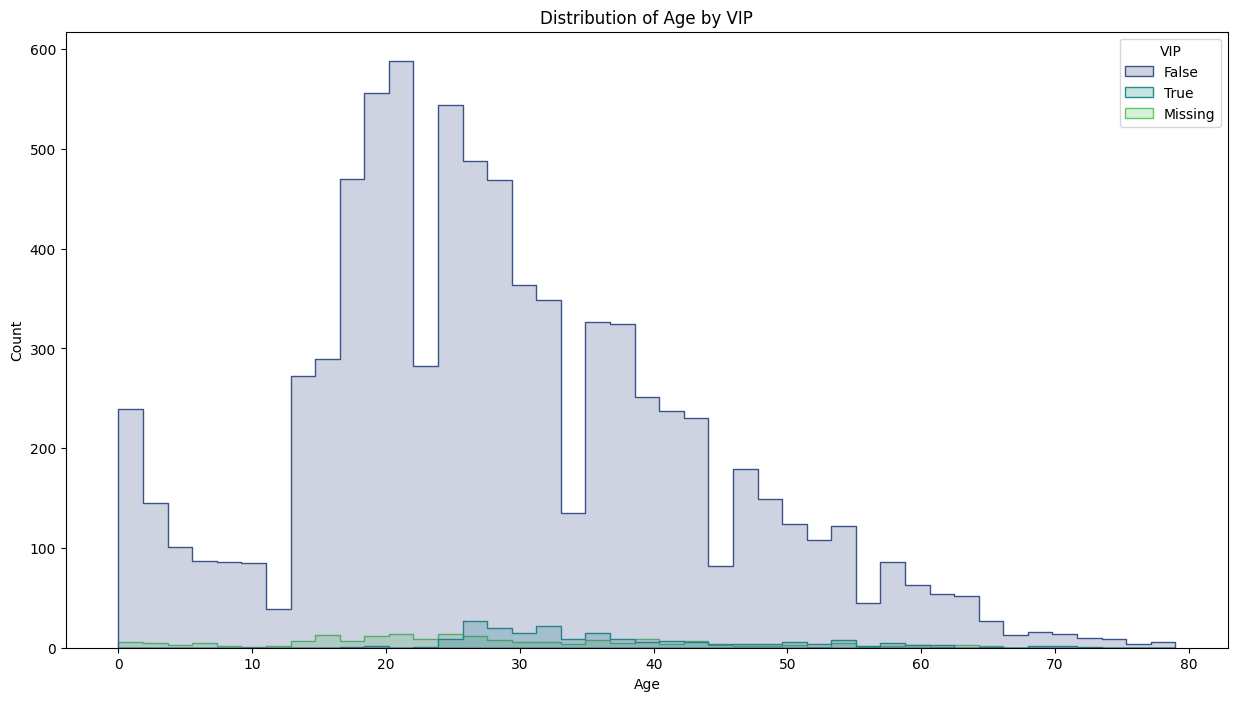

In [23]:
df = data_train.copy()

df['VIP'].fillna('Missing', inplace=True)
plt.figure(figsize=(15, 8))
sns.histplot(data=df, x='Age', hue='VIP', element="step", palette='viridis',)
plt.title('Distribution of Age by VIP')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [24]:
df[df['VIP'] == True]['Age'].min()

18.0

Conclusions from graph:
- there are no passengers with VIP status younger than 18 years (in pipleline this threshold will be adjustable)

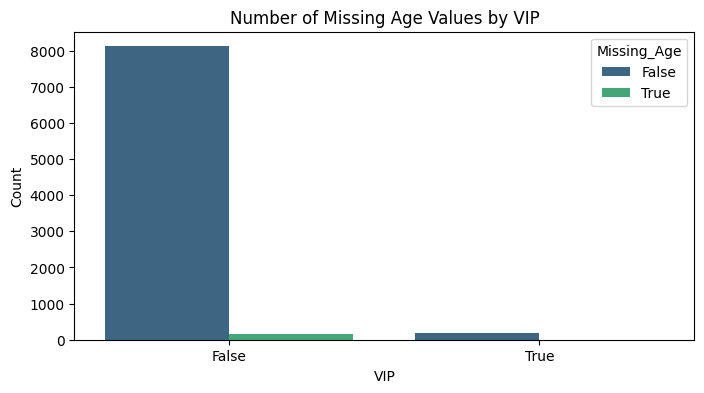

In [25]:
df = data_train.copy()

df['Missing_Age'] = df['Age'].isna()
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='VIP', hue='Missing_Age', palette='viridis')
plt.title('Number of Missing Age Values by VIP')
plt.ylabel('Count')
plt.show()


In [26]:
df = data_train.copy()
missing_rows = df[df['VIP'].isnull() & df['Age'].isnull()]
missing_rows.shape


(6, 18)

Conclusions from graph:
- missing Age values are only from non-VIP passenger (TBD in pipeline)


### Dristributions

Numeric data

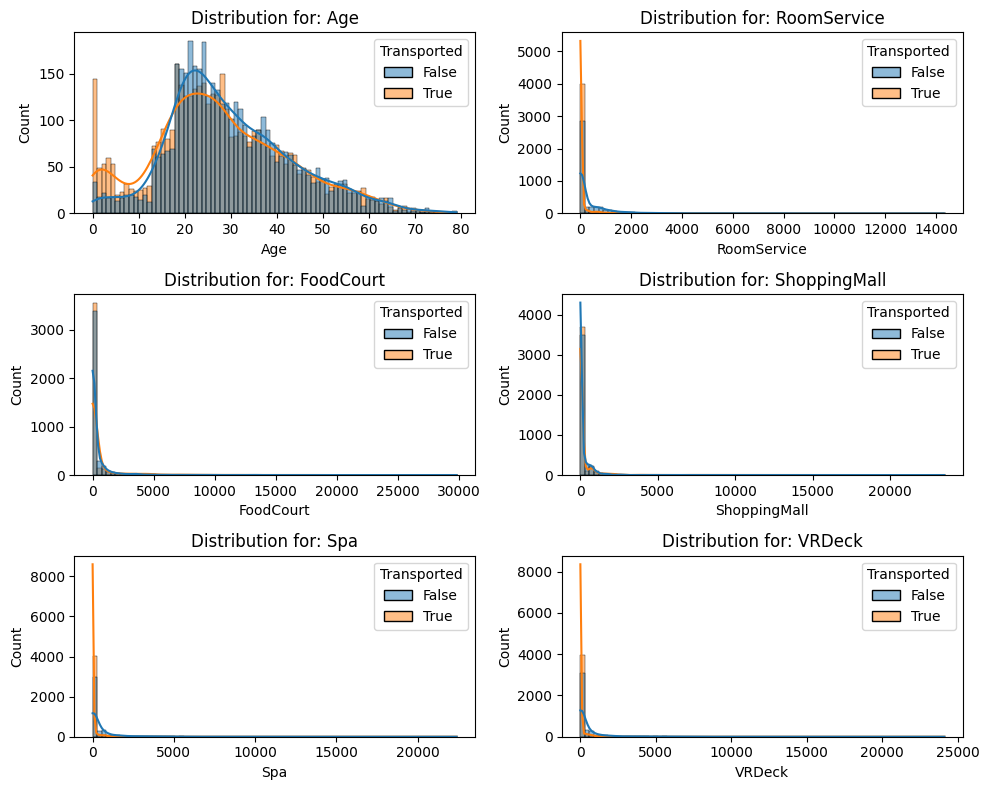

In [27]:
df = data_train.copy()

continous_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

plt.figure(figsize=(10, 8))  

n_rows = 3
n_cols = 2

for index, col in enumerate(continous_columns):
    plt.subplot(n_rows, n_cols, index+1)
    sns.histplot(data=df, x=col, hue='Transported', kde=True, bins=80 )
    plt.title(f"Distribution for: {col}")

plt.tight_layout()  
plt.show()


Binned numeric data

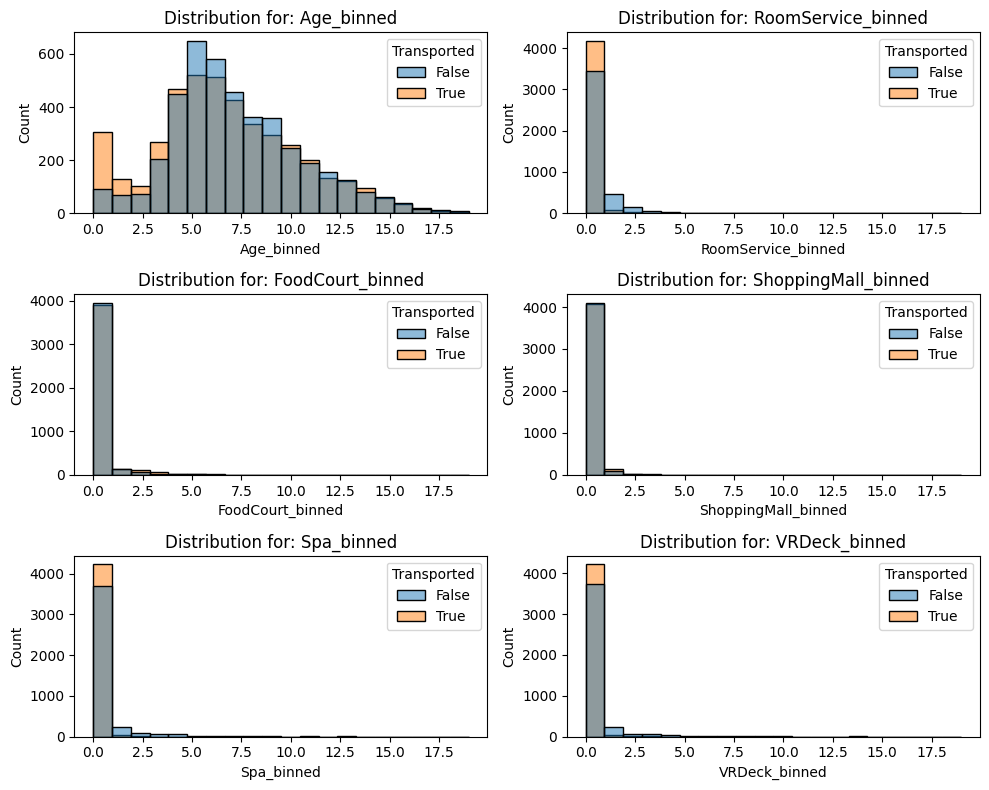

In [28]:
df = data_train.copy()

continous_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Dzieląc kolumny na biny
num_bins = 20
for col in continous_columns:
    df[col + '_binned'] = pd.cut(df[col], bins=num_bins, labels=False)

# Aktualizacja listy kolumn do wykresów
binned_columns = [col + '_binned' for col in continous_columns]

plt.figure(figsize=(10, 8))  

n_rows = 3
n_cols = 2

for index, col in enumerate(binned_columns):
    plt.subplot(n_rows, n_cols, index+1)
    sns.histplot(data=df, x=col, hue='Transported', bins=num_bins)
    plt.title(f"Distribution for: {col}")

plt.tight_layout()
plt.show()


VIP

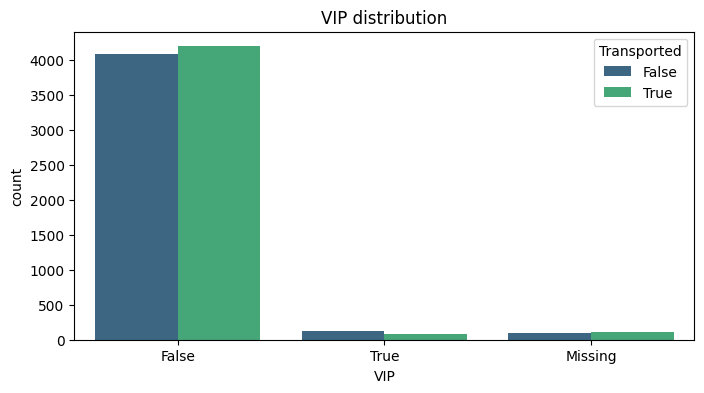

In [29]:

df = data_train.copy()
df = df.fillna('Missing')
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='VIP', hue='Transported', palette='viridis')
plt.title("VIP distribution")
plt.show()
